<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/notebooks/augment_segmented_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install imgaug
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.5/792.5 kB 9.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [56]:
from imgaug import augmenters as iaa
from PIL import Image
from pathlib import Path
from ultralytics import YOLO
import imgaug as ia
import imageio
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [57]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [61]:
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5

In [64]:
def augment_png(source_png_folder_path, augmented_png_folder_path, number_of_augs_plus_originals):
  """
  Reads a folder of PNG images, applies augmentations, and saves as PNG.

  Args:
      source_png_folder__path: Path to the input folder of PNG images.
      augmented_png_folder_path: Path to the output folder of augmented PNG images
      number_of_augs_plus_originals: Number of augmented images to be generated, less
         the number of original images, so we end up with (close to) number_of_augs_plus_originals
         images in toto.
  """

  # Read all the PNG files in the source folder
  png_files = glob.glob(os.path.join(source_png_folder_path, '*.png'))
  png_images = [cv2.imread(png_path, cv2.IMREAD_COLOR) for png_path in png_files]


  # Calculate number of augmentations to make of each image.  Since we're doing
  # integer division, we won't always end up with exactly number_of_augs_plus_originals
  # images (augmented plus originals).  But this will be close enough to give us
  # a balanced training set.
  number_of_augs = number_of_augs_plus_originals - len(png_images)
  number_of_augs_per_original = number_of_augs // len(png_images)
  if number_of_augs_per_original == 0:
    number_of_augs_per_original = 1


  # Define augmentation sequence
  augment_seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
  ], random_order=True) # apply augmenters in random order

  trained_model = YOLO('/content/gdrive/MyDrive/Cat images/models/feral-cat-segmentation.v1i.yolov8/200-epochs-/weights/best.pt') #(4)!

  # Loop to augment each original N times and write it out.
  for idx, filepath in enumerate(png_files):
    # Augment the next original image N times, where N = number_of_augs_per_original
    augmented_images = augment_seq(images=[png_images[idx] for i in range(number_of_augs_per_original)])

    # This code extracts each object from an image using its segmentation mask predicted by the YOLO v8 feral cat segmentation model.
    # This code was adapted (slightly) from the code in the YOLO v8 documentation, which can be found at
    # https://docs.ultralytics.com/guides/isolating-segmentation-objects/#recipe-walk-through.  The numbers in parentheses refer to steps
    # and explanations in that documentation.


    # validation_image = Image.open(validation_image_path)
    res = trained_model.predict(augmented_images, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD) #(3)!

    # iterate detection results (5)
    for r in res:
      img = np.copy(r.orig_img)
      img_name = Path(r.path).stem

      # iterate each object contour (6)
      for ci,c in enumerate(r):
        label = c.names[c.boxes.cls.tolist().pop()]

        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask (1)
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        # Choose one:

        # OPTION-1: Isolate object with black background
        # mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)
        # isolated = cv2.bitwise_and(mask3ch, img)

        # OPTION-2: Isolate object with transparent background (when saved as PNG)
        isolated = np.dstack([img, b_mask])

        # OPTIONAL: detection crop (from either OPT1 or OPT2)
        x1, y1, x2, y2 = c.boxes.xyxy.cpu().numpy().squeeze().astype(np.int32)
        iso_crop = isolated[y1:y2, x1:x2]

        # Save isolated object to file
        _ = cv2.imwrite(f'{augmented_png_folder_path}/{img_name}_{label}-{ci}_aug-{idx}.png', iso_crop)

  # Loop to copy the original PNG files to the augmented directory
  for png_path in png_files:
    png_image = cv2.imread(png_path, cv2.IMREAD_COLOR)
    # Replace the directory with the new folder name
    copy_path = png_path.replace(source_png_folder_path, augmented_png_folder_path)
    cv2.imwrite(copy_path, png_image)


In [ ]:
def augment_png_to_jpg(png_folder_path, jpg_folder_path, number_of_augs_plus_originals):
  """
  Reads a folder of PNG images, applies augmentations, and saves as JPG.

  Args:
      png_folder__path: Path to the input folder of PNG images.
      jpg_folder_path: Path to the output folder of JPG images
      number_of_augs_plus_originals: Number of augmented images to be generated, less
         the number of original images, so we end up with (close to) number_of_augs_plus_originals
         images in toto.
  """

  # Read all the PNG files in the source folder
  png_files = glob.glob(os.path.join(png_folder_path, '*.png'))
  png_images = [cv2.imread(png_path, cv2.IMREAD_COLOR) for png_path in png_files]

  # Calculate number of augmentations to make of each image.  Since we're doing
  # integer division, we won't always end up with exactly number_of_augs_plus_originals
  # images (augmented plus originals).  But this will be close enough to give us
  # a balanced training set.
  number_of_augs = number_of_augs_plus_originals - len(png_images)
  number_of_augs_per_original = number_of_augs // len(png_images)
  if number_of_augs_per_original == 0:
    number_of_augs_per_original = 1


  # Define augmentation sequence
  augment_seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

  # Loop to augment each original N times, convert to JPG, and write it out.
  for idx, filepath in enumerate(png_files):
    # Augment the next original image N times, where N = number_of_augs_per_original
    augmented_images = augment_seq(images=[png_images[idx] for i in range(number_of_augs_per_original)])

    # Convert augmented images to RGB (common for JPEG)
    rgb_images = [cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB) for augmented_image in augmented_images]

    for i in range(number_of_augs_per_original):
      jpg_path = ''
      base, ext = os.path.splitext(filepath)
      if ext.lower() == ".png":  # Check if extension is png (case-insensitive)
        jpg_path = base + f"_aug-{i}.jpg"
        # Split the filepath into directory and filename
        directory, filename = os.path.split(jpg_path)
        # Join the directory with the new folder name
        jpg_path = os.path.join(directory.replace(png_folder_path, jpg_folder_path), filename)
        cv2.imwrite(jpg_path, rgb_images[i])

  # Loop to convert the original PNG files to JPG
  for png_path in png_files:
    png_image = cv2.imread(png_path, cv2.IMREAD_COLOR)
    rgb_image = cv2.cvtColor(png_image, cv2.COLOR_BGR2RGB)
    base, ext = os.path.splitext(png_path)
    if ext.lower() == ".png":  # Check if extension is png (case-insensitive)
      jpg_path = base + ".jpg"
      # Split the filepath into directory and filename
      directory, filename = os.path.split(jpg_path)
      # Join the directory with the new folder name
      jpg_path = os.path.join(directory.replace(png_folder_path, jpg_folder_path), filename)
      cv2.imwrite(jpg_path, rgb_image)


In [66]:
IMAGE_FILENAME_ROOT = 'composite_red_white'
!unzip '{IMAGE_FILENAME_ROOT}_segmented.zip'
!mkdir {IMAGE_FILENAME_ROOT}_augmented
source_png_folder_path = f'{IMAGE_FILENAME_ROOT}_segmented'
augmented_png_folder_path = f'{IMAGE_FILENAME_ROOT}_augmented'
augment_png(source_png_folder_path,augmented_png_folder_path, 10)
!zip -r '{IMAGE_FILENAME_ROOT}_augmented.zip' '{IMAGE_FILENAME_ROOT}_augmented'

Archive:  composite_red_white_segmented.zip
   creating: composite_red_white_segmented/
  inflating: __MACOSX/._composite_red_white_segmented  
  inflating: composite_red_white_segmented/comp_red_white_0003_cat-0.png  
  inflating: __MACOSX/composite_red_white_segmented/._comp_red_white_0003_cat-0.png  
  inflating: composite_red_white_segmented/comp_red_white_0002_cat-0.png  
  inflating: __MACOSX/composite_red_white_segmented/._comp_red_white_0002_cat-0.png  
  inflating: composite_red_white_segmented/comp_red_white_0001_cat-0.png  
  inflating: __MACOSX/composite_red_white_segmented/._comp_red_white_0001_cat-0.png  

0: 544x640 1 cat, 2894.0ms
1: 544x640 1 cat, 2894.0ms
Speed: 7.7ms preprocess, 2894.0ms inference, 5.6ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 1 cat, 1595.3ms
1: 480x640 1 cat, 1595.3ms
Speed: 4.9ms preprocess, 1595.3ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cat, 1716.1ms
1: 480x640 1 cat, 1716.1ms
Speed: 5.4

<ipython-input-54-1748194b0c05>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('orange_augmented/orange_0006_cat-0_aug-0.png')


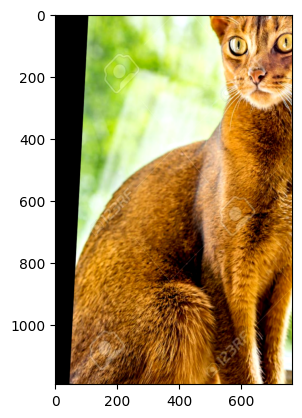

In [54]:
image = imageio.imread('orange_augmented/orange_0006_cat-0_aug-0.png')
plt.imshow(image)
plt.show;

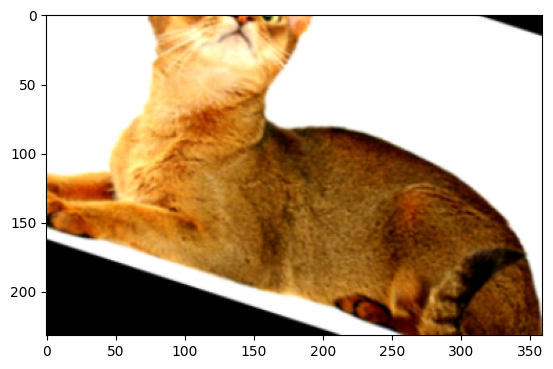

In [12]:
plt.imshow(image)
plt.show;

In [6]:
from PIL import Image

def copy_png_with_transparency(png_path, copy_path):
  """
  Copies a PNG image while preserving its transparency.

  Args:
      png_path: Path to the original PNG image.
      copy_path: Path to save the copied PNG image.
  """
  # Open the PNG image
  img = Image.open(png_path)

  # Check if the image has transparency (alpha channel)
  if img.mode == 'RGBA':
    # Copy the image with the same mode (RGBA) to preserve transparency
    img_copy = img.copy()
  else:
    # Image doesn't have transparency, simply copy the data
    img_copy = img.convert('RGBA')  # Convert to RGBA for consistency

  # Save the copied image as PNG
  img_copy.save(copy_path, format='PNG')

# Example usage
png_file = "orange_segmented/orange_0001_cat-0.png"
copy_file = "orange_segmented/orange_0001_cat-0_copy.png"
copy_png_with_transparency(png_file, copy_file)


<ipython-input-8-b69f37425869>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(copy_file)


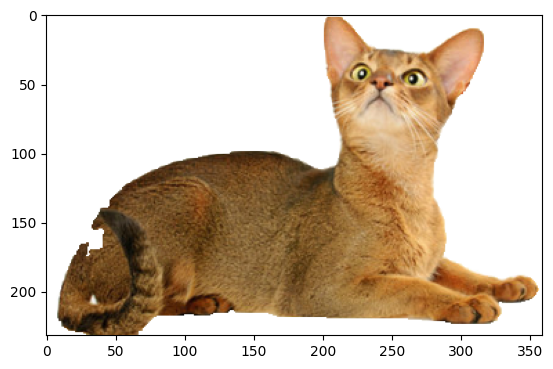

In [8]:
image = imageio.imread(copy_file)
plt.imshow(image)
plt.show;

In [65]:
augment_png(source_png_folder_path,augmented_png_folder_path, 20)
!zip -r '{IMAGE_FILENAME_ROOT}_augmented.zip' '{IMAGE_FILENAME_ROOT}_augmented'


0: 640x416 1 cat, 2546.1ms
Speed: 2.9ms preprocess, 2546.1ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 1 cat, 1394.9ms
Speed: 4.3ms preprocess, 1394.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 320)

0: 416x640 1 cat, 1555.5ms
Speed: 2.9ms preprocess, 1555.5ms inference, 4.7ms postprocess per image at shape (1, 3, 416, 640)

0: 640x512 1 cat, 2000.2ms
Speed: 4.8ms preprocess, 2000.2ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 512)

0: 576x640 1 cat, 2128.6ms
Speed: 6.1ms preprocess, 2128.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 640)

0: 416x640 1 cat, 1524.1ms
Speed: 3.9ms preprocess, 1524.1ms inference, 4.3ms postprocess per image at shape (1, 3, 416, 640)

0: 640x576 2 cats, 2812.1ms
Speed: 5.1ms preprocess, 2812.1ms inference, 19.1ms postprocess per image at shape (1, 3, 640, 576)

0: 544x640 1 cat, 3175.2ms
Speed: 4.6ms preprocess, 3175.2ms inference, 9.0ms postprocess per image at shape